#1. Darknet Clone

> GPU



In [1]:
# clone repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15097, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 15097 (delta 8), reused 9 (delta 2), pack-reused 15072
Receiving objects: 100% (15097/15097), 13.48 MiB | 14.32 MiB/s, done.
Resolving deltas: 100% (10253/10253), done.


In [2]:
%cd darknet

/content/darknet


In [3]:
# change makefile to have GPU, OPENCV, CUDNN enabled
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

In [4]:
# compile sources
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

In [5]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-06-14 07:18:00--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  23.1MB/s    in 11s     

2021-06-14 07:18:12 (21.4 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



#2. Tracking

In [6]:
import cv2
import IPython
import numpy as np
import time
import math
from google.colab.patches import cv2_imshow

In [7]:
MIN_CONFIDENCE = 0.5
weight_file = 'yolov3.weights'
cfg_file = 'cfg/yolov3.cfg'
name_file = 'data/coco.names'
file_name = 'traffic_video.mp4'

In [8]:
# load Yolo
net = cv2.dnn.readNet(weight_file, cfg_file)

In [9]:
classes = []
with open(name_file, 'r') as f:
  classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0]-1] for i in net.getUnconnectedOutLayers()]

In [10]:
# upload traffic_sign_video.mp4
from google.colab import files
files.upload()

Saving traffic_video.mp4 to traffic_video.mp4


In [11]:
def writeFrame(img):
  global writer
  height, width = img.shape[:2]
  if writer is None and output_name is not None:
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter(output_name, fourcc, 24, (width, height), True)
  if writer is not None:
    writer.write(img)

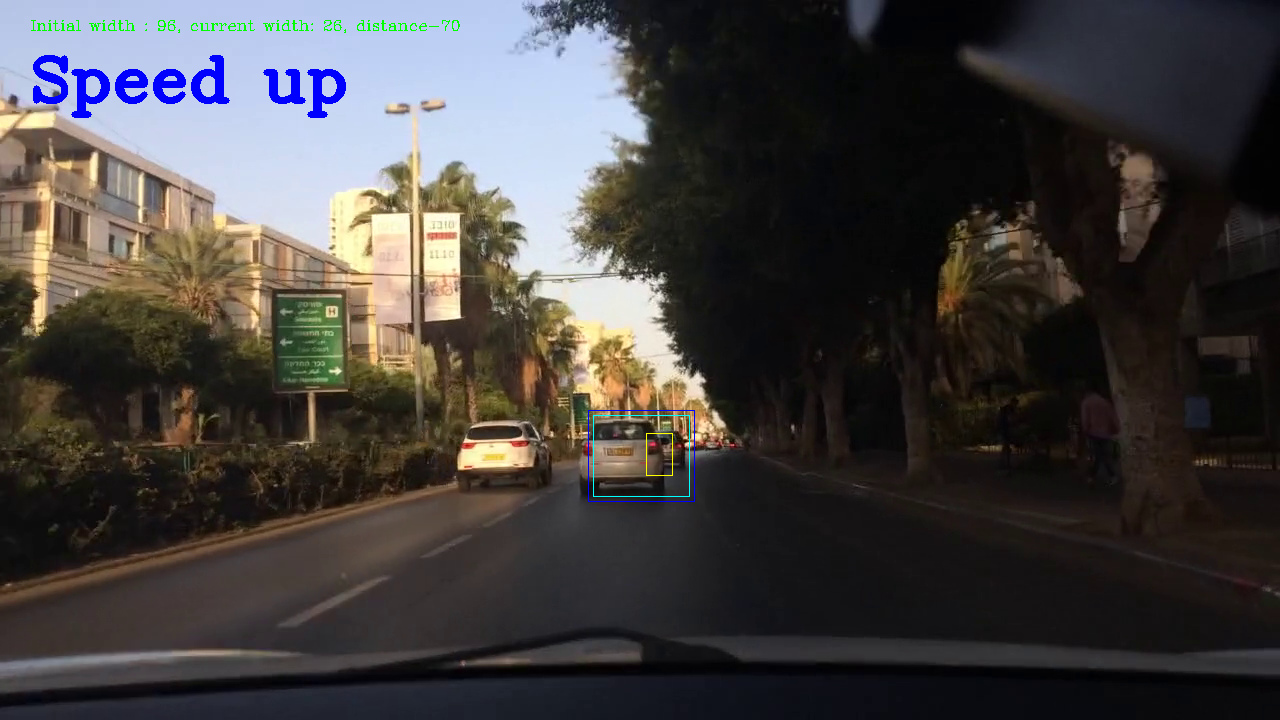

[Tracking] Frame 379 time 2.345529079437256


In [ ]:
frame_count = 0
writer = None
output_name = 'output_car_tracking.avi'

detected = False
frame_mode = 'Tracking'
elapsed_time = 0
margin = 70
tracker = cv2.TrackerKCF_create()
trackers = cv2.MultiTracker_create()

detected_width = 0
vs = cv2.VideoCapture(file_name)

while True:
  start_time = time.time()
  frame_count += 1
  ret, frame = vs.read()
  if frame is None:
    print("##No more frame##")
    break
  IPython.display.clear_output(wait=True)
  height, width, channels = frame.shape
  
  class_ids = []
  confidences = []
  boxes = []
  roi_left = int(0.3*width)
  roi_right = int(0.6*width)

  if detected:
    frame_mode = 'Tracking'
    (success, tracking_boxes) = trackers.update(frame)
    tracking_box = tracking_boxes[0]
    tx = int(tracking_box[0])
    ty = int(tracking_box[1])
    tw = int(tracking_box[2])
    th = int(tracking_box[3])
    roi = frame[ty-margin:ty+th+margin, tx-margin:tx+tw+margin] # add the margin to increase recognition performance
    roi_width, roi_height = roi.shape[:2]
    blob = cv2.dnn.blobFromImage(roi, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    net.setInput(blob)
    outs = net.forward(output_layers)

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            # filter only car
            if confidence > MIN_CONFIDENCE and (class_id==2):
                # Object detected
                center_x = int(detection[0] * roi_width)
                center_y = int(detection[1] * roi_height)
                w = int(detection[2] * roi_width)
                h = int(detection[3] * roi_height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])

    if len(boxes):
      boxes.sort(key=lambda x: x[2], reverse=True)
      box = boxes[0]
      x = box[0]
      y = box[1]
      w = box[2]
      h = box[3]
      roi_x = tx-margin+x
      roi_y = ty-margin+y
      distance_width = w-detected_width
      cv2.rectangle(frame, (roi_x,roi_y), (roi_x+w,roi_y+h), (0,255,255), 1)
      label = "Initial width : " + str(detected_width) + ', current width: ' + str(w) + ", distance" + str(w-detected_width)
      print(box, label)
      if abs(distance_width) > 5:
        if distance_width < 0:
          cv2.putText(frame, "Speed up", (30,100), cv2.FONT_HERSHEY_COMPLEX, 2, (255,0,0), 5)
        elif distance_width < 30:
          cv2.putText(frame, "Slow down", (30,100), cv2.FONT_HERSHEY_COMPLEX, 2, (0,128,255), 5)
        else:
          cv2.putText(frame, "Be careful", (30,100), cv2.FONT_HERSHEY_COMPLEX, 2, (0,0,255), 5)
      cv2.putText(frame, label, (30,30), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,255,0), 1)
    cv2.rectangle(frame, (tx,ty), (tx+tw,ty+th), (255,255,0), 1)
    cv2.rectangle(frame, (tx-margin,ty-margin), (tx+tw+margin,ty+th+margin), (255,0,0), 1)
  
  else:
    frame_mode = 'Detection'
    height, width, channels = frame.shape
    # Detecting objects
    # https://docs.opencv.org/master/d6/d0f/group__dnn.html
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    net.setInput(blob)
    outs = net.forward(output_layers)

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            # filter only car
            if confidence > MIN_CONFIDENCE and (class_id==2):
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, MIN_CONFIDENCE, 0.4)
    font = cv2.FONT_HERSHEY_COMPLEX
    margin = 5
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            # eliminate small object
            if w>50 and x>roi_left and x<roi_right:
              selected = boxes[i]
              detected_width = w
              cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 5)
    trackers.add(tracker, frame, tuple(selected))
    detected = True

  cv2_imshow(frame)
  writeFrame(frame)
  frame_time = time.time() - start_time
  elapsed_time += frame_time
  print("[{}] Frame {} time {}".format(frame_mode, frame_count, frame_time))

print("Elapsed time {}".format(elapsed_time))
vs.release()